# Google's Word2Vec Long Short Term Memory (LSTM)

Importing all the required libraries along with some instance variables initialization.

It is important to note that **INPUT_SIZE** plays a big role in the model convergence.  
The value should be the average number of words per review.  
This shall yield the most optimum model state for faster convergence across the network.

**EPOCHS** is set to `10` only to select the best model with the best hyper-parameters configuration for the fastest network convergence.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from gensim.models import KeyedVectors
from keras.backend.tensorflow_backend import set_session
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Embedding, Dropout, Flatten
from tensorflow.python.keras.layers import LSTM, SimpleRNN
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.preprocessing import text as keras_text, sequence as keras_seq
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
from sklearn.utils import shuffle
from tensorflow import set_random_seed
import gc
import os

#myrand=np.random.randint(1, 99999 + 1)
myrand=58584
np.random.seed(myrand)
set_random_seed(myrand)
z=0

EMBEDDING_SIZE=300
WORDS_SIZE=8000
INPUT_SIZE=100
NUM_CLASSES=2
EPOCHS=10

# To allow dynamic GPU memory allowcation for model training
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  
config.log_device_placement = True

sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


Importing all the data from:
 * eRezeki
 * IMDB
 * Amazon
 * Yelp


In [2]:
mydata = pd.read_csv('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/eRezeki/eRezeki_(text_class)_unclean.csv',header=0,encoding='utf-8')
mydata = mydata.loc[mydata['sentiment'] != "neutral"]
mydata['sentiment'] = mydata['sentiment'].map({'negative': 0, 'positive': 1})

mydata1 = pd.read_csv('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/IMDB/all_random.csv',header=0,encoding='utf-8')
mydata = mydata.append(mydata1)
mydata = shuffle(mydata)

mydata1 = pd.read_csv('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/Amazon(sports_outdoors)/Amazon_UCSD.csv',header=0,encoding='utf-8')
mydata1['feedback'] = mydata1['feedback'].astype(str)
mydata = mydata.append(mydata1)
mydata = shuffle(mydata)

mydata1 = pd.read_csv('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/Yelp(zhang_paper)/yelp_zhang.csv',header=0,encoding='utf-8')
mydata1['feedback'] = mydata1['feedback'].astype(str)
mydata = mydata.append(mydata1)

del(mydata1)
gc.collect()

mydata = shuffle(mydata)
mydata = shuffle(mydata)
mydata = shuffle(mydata)

Spllitting the data into training (70%) and testing (30%) sets.

In [3]:
x_train, x_test, y_train, y_test = train_test_split(mydata.iloc[:,0], mydata.iloc[:,1],
                                                    test_size=0.3, 
                                                    random_state=myrand, 
                                                    shuffle=True)
old_y_test = y_test

Prepare tokenizer

In [4]:
## Create tokkenizer from full list of texts
tokenizer = keras_text.Tokenizer(char_level=False)
tokenizer.fit_on_texts(list(mydata['feedback']))
tokenizer.num_words=WORDS_SIZE

Create sequence file from the tokkenizer for training and testing sets.

In [5]:
## Tokkenizing train data and create matrix
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = keras_seq.pad_sequences(list_tokenized_train, 
                                  maxlen=INPUT_SIZE,
                                  padding='post')
x_train = x_train.astype(np.int64)

## Tokkenizing test data and create matrix
list_tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = keras_seq.pad_sequences(list_tokenized_test, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_test = x_test.astype(np.int64)

Perform One Hot Encoding (OHE) to the labes of training and testing sets.

In [6]:
y_train = to_categorical(y_train, num_classes=NUM_CLASSES).astype(np.int64)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES).astype(np.int64)

Prepare **Word2Vec LSTM** embeddings layer

In [7]:
word2vec = KeyedVectors.load_word2vec_format('../../../../../Master (Sentiment Analysis)/Paper/Paper 3/Datasets/googlew2v/GoogleNews-vectors-negative300.bin', binary=True)
word_index = tokenizer.word_index

vocabulary_size=min(len(word_index)+1,8000)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_SIZE))
for word, i in word_index.items():
    if i>=WORDS_SIZE:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_SIZE)

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=INPUT_SIZE,
                            trainable=False)

Define and build the **Word2Vec LSTM** model

In [8]:
model = Sequential(name='Word2Vec LSTM')

model.add(embedding_layer)
model.add(LSTM(250))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(2, activation='softmax'))

## Define multiple optional optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0, amsgrad=False)

## Compile model with metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Word2Vec LSTM model built: ")
model.summary()

Word2Vec LSTM model built: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          2400000   
_________________________________________________________________
lstm (LSTM)                  (None, 250)               551000    
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               62750     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 502       
Total params: 3,014,252
Trainable params: 614,252
Non-trainable params: 2,400,000
_________________________________________________________________


Create **TensorBoard callbacks** for:
 * Historical data
 * Training and evaluation gain/loss
 
Also, create the **best-model callback** to save the **best** model every epoch.

In [9]:
## Create TensorBoard callbacks

callbackdir= '/project/ten'

tbCallback = TensorBoard(log_dir=callbackdir, 
                         histogram_freq=0, 
                         batch_size=128,
                         write_graph=True, 
                         write_grads=True, 
                         write_images=True)

tbCallback.set_model(model)

mld = '/project/model/word2vec_lstm.hdf5_%s'%(z)

## Create best model callback
mcp = ModelCheckpoint(filepath=mld, monitor="val_acc",
                      save_best_only=True, mode='max', period=1, verbose=1)

**Train** the model

In [10]:
print('Training the Word2Vec LSTM model')
history = model.fit(x = x_train,
          y = y_train,
          validation_data = (x_test, y_test),
          epochs = EPOCHS,
          batch_size = 128,
          verbose =2,
          callbacks=[mcp,tbCallback])

Training the Word2Vec LSTM model
Train on 663700 samples, validate on 284443 samples
Epoch 1/10
 - 609s - loss: 0.2823 - acc: 0.8817 - val_loss: 0.2247 - val_acc: 0.9091

Epoch 00001: val_acc improved from -inf to 0.90908, saving model to /project/model/word2vec_lstm.hdf5_0
Epoch 2/10
 - 607s - loss: 0.2063 - acc: 0.9161 - val_loss: 0.2726 - val_acc: 0.9010

Epoch 00002: val_acc did not improve from 0.90908
Epoch 3/10
 - 607s - loss: 0.1852 - acc: 0.9257 - val_loss: 0.1804 - val_acc: 0.9278

Epoch 00003: val_acc improved from 0.90908 to 0.92776, saving model to /project/model/word2vec_lstm.hdf5_0
Epoch 4/10
 - 607s - loss: 0.1662 - acc: 0.9340 - val_loss: 0.1765 - val_acc: 0.9293

Epoch 00004: val_acc improved from 0.92776 to 0.92929, saving model to /project/model/word2vec_lstm.hdf5_0
Epoch 5/10
 - 607s - loss: 0.1487 - acc: 0.9414 - val_loss: 0.1756 - val_acc: 0.9300

Epoch 00005: val_acc improved from 0.92929 to 0.92999, saving model to /project/model/word2vec_lstm.hdf5_0
Epoch 6/10

**Predict** the testing set using the best model from the run.

In [11]:
print('\nPredicting the model')
model = load_model(mld)
results = model.evaluate(x_test, y_test, batch_size=128)
for num in range(0,2):
    print(model.metrics_names[num]+': '+str(results[num]))


Predicting the model
284443/284443 [==============================] - 79s 278us/step
loss: 0.17432800445191066
acc: 0.9328793466550277


**Evaluate** the performance of the model on the testing set using:
 * Confusion matrix
 * Accuracy
 * Precision
 * Recall
 * F-Measure

In [12]:
print('\nConfusion Matrix')
predicted = model.predict_classes(x_test)
confusion = confusion_matrix(y_true=old_y_test, y_pred=predicted)
print(confusion)

## Performance measure
print('\nWeighted Accuracy: '+ str(accuracy_score(y_true=old_y_test, y_pred=predicted)))
print('Weighted precision: '+ str(precision_score(y_true=old_y_test, y_pred=predicted, average='weighted')))
print('Weighted recall: '+ str(recall_score(y_true=old_y_test, y_pred=predicted, average='weighted')))
print('Weighted f-measure: '+ str(f1_score(y_true=old_y_test, y_pred=predicted, average='weighted')))



Confusion Matrix
[[ 98361  11777]
 [  7315 166990]]

Weighted Accuracy: 0.9328793466529323
Weighted precision: 0.9328269219073599
Weighted recall: 0.9328793466529323
Weighted f-measure: 0.9326096034437591


**Plot** the model training history for training and evaluation sets.

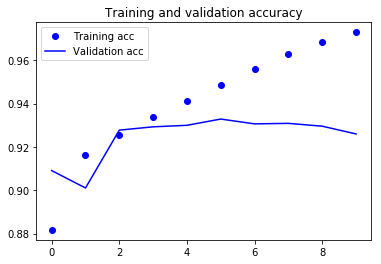

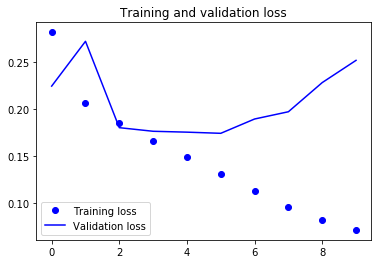

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()